In [67]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
from time import time

In [29]:
#   CARGA DE HDF5
# ==============================
# CARGA DIRECTA DE TRAIN/VAL
h5_train = h5py.File("train_128.h5", "r")
train_images = h5_train["images"]
train_labels = h5_train["labels"]

h5_val = h5py.File("val_128.h5", "r")
val_images = h5_val["images"]
val_labels = h5_val["labels"]

print("Train:", train_images.shape, "Val:", val_images.shape)

Train: (12372, 128, 128, 3) Val: (2651, 128, 128, 3)


In [30]:
# MIXED PRECISION
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [59]:
tipos_galaxia = {
    0: "spiral",
    1: "elliptical",
    2: "lenticular",
    3: "irregular",
    4: "merger",
    5: "unknown",
    6: "barred spiral",
    7: "compact",
    8: "edge-on",
    9: "uncertain"
} #el dataset no ofrece la equivalencia y las etiquetas solo son numeros, por eso recurrimos a la docuentación oficial del dataset para hacer la lista manualmente

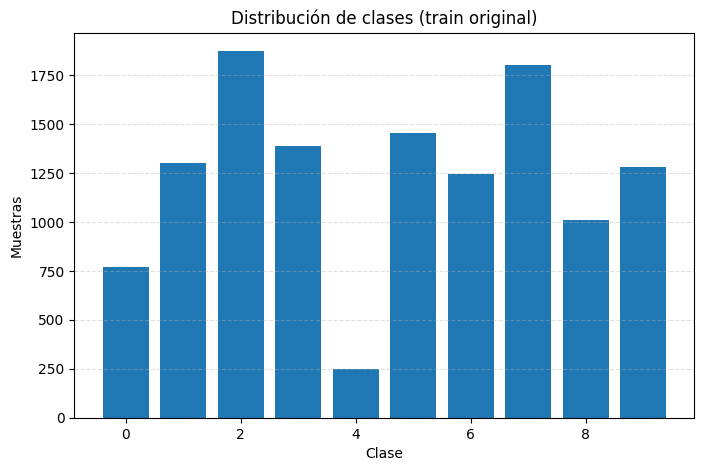

In [32]:
# DISTRIBUCIÓN ORIGINAL EN TRAIN
classes, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8,5))
plt.bar(classes, counts)
plt.title("Distribución de clases (train original)")
plt.xlabel("Clase")
plt.ylabel("Muestras")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

In [33]:
# BALANCEO OFFLINE (sobre índices de train)
unique_classes, counts = np.unique(train_labels, return_counts=True)

min_target = 1200
balanced_indices = []

for c, cnt in zip(unique_classes, counts):
    class_idx = np.where(train_labels[:] == c)[0]
    if cnt > min_target:
        sel = np.random.choice(class_idx, min_target, replace=False)
    else:
        sel = np.random.choice(class_idx, min_target, replace=True)
    balanced_indices.extend(sel)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

print("Nuevo tamaño del train balanceado:", len(balanced_indices))

Nuevo tamaño del train balanceado: 12000


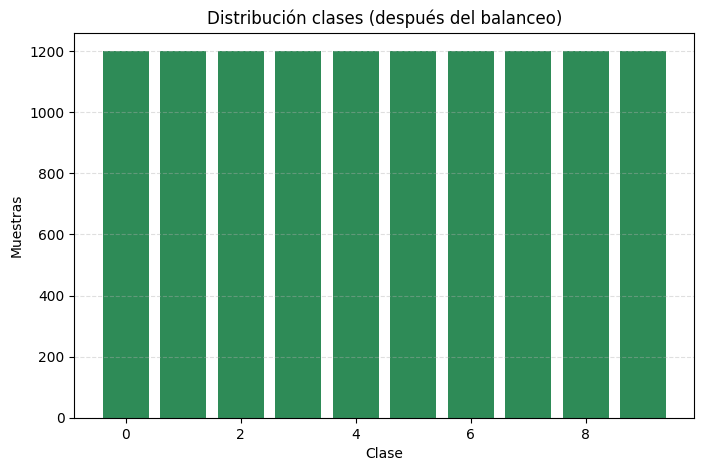

In [34]:
# DISTRIBUCIÓN TRAS BALANCEO
balanced_lbls = np.array([train_labels[i] for i in balanced_indices])
c2, cnt2 = np.unique(balanced_lbls, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(c2, cnt2, color="seagreen")
plt.title("Distribución clases (después del balanceo)")
plt.xlabel("Clase")
plt.ylabel("Muestras")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

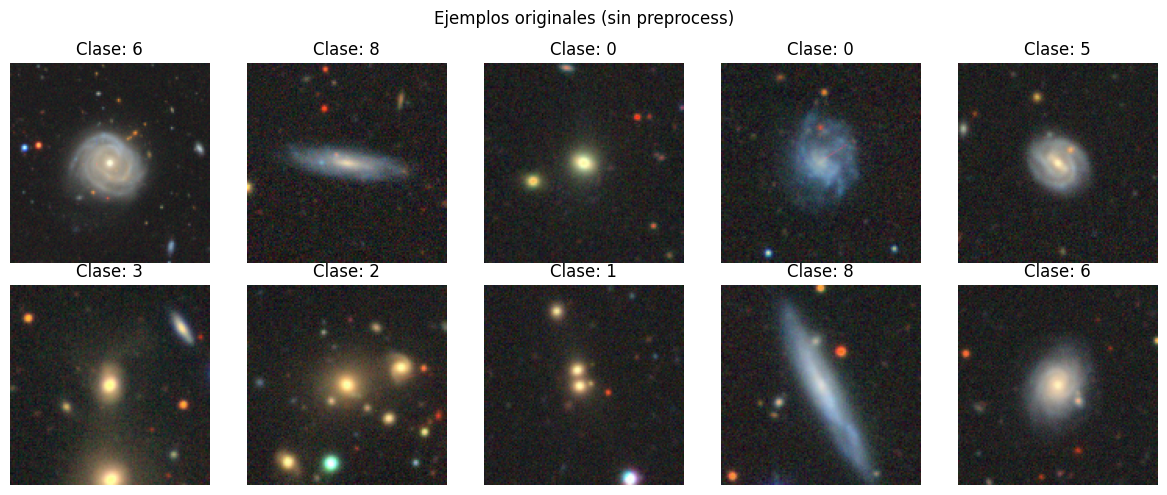

In [35]:
# Visualización directa desde HDF5 (sin preprocess)
idx = np.random.randint(0, len(train_images), 10)

plt.figure(figsize=(12,5))
for i, id_img in enumerate(idx):
    img = train_images[id_img]  # sin cast, sin preprocess
    lbl = train_labels[id_img]

    plt.subplot(2,5,i+1)
    plt.imshow(img)  # rango 0..255 correcto
    plt.title(f"Clase: {lbl}")
    plt.axis("off")

plt.suptitle("Ejemplos originales (sin preprocess)")
plt.tight_layout()
plt.show()

In [36]:
# PREPROCESADO Y DATASETS

from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 224
batch_size = 64

def load_train(i):
    i = int(i)
    return train_images[i], train_labels[i]

def load_val(i):
    i = int(i)
    return val_images[i], val_labels[i]

def preprocess(i, mode="train"):
    if mode == "train":
        img, lbl = tf.py_function(load_train, [i], [tf.uint8, tf.int32])
    else:
        img, lbl = tf.py_function(load_val, [i], [tf.uint8, tf.int32])

        # Ajustamos el shape original de entrada
    img.set_shape([128,128,3])  # ← el dataset está en 128, dejamos esto igual
    lbl.set_shape([])

    # Resize EXACTAMENTE aquí
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocesado para EfficientNet
    img = preprocess_input(tf.cast(img, tf.float32))

    img = preprocess_input(tf.cast(img, tf.float32))

    return img, lbl

In [37]:
# Augment solo imágenes
aug_layers = tf.keras.Sequential([
    layers.RandomRotation(0.4),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.15),
])

def augment(img, lbl):
    return aug_layers(img), lbl

In [38]:
#   CREACIÓN DE DATASETS con tf.data (solo imágenes)
def create_ds(indices, mode="train", aug=False):
    ds = tf.data.Dataset.from_tensor_slices(indices)
    ds = ds.shuffle(5000)
    ds = ds.map(lambda x: preprocess(x, mode), num_parallel_calls=tf.data.AUTOTUNE)
    if aug:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_ds(balanced_indices, mode="train", aug=True)
val_indices = np.arange(len(val_images))
val_ds = create_ds(val_indices, mode="val", aug=False)

In [39]:
#   MODELO EfficientNetB0 (solo imágenes)
img_input = Input(shape=(224,224,3))
base = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=img_input)
base.trainable = False
for layer in base.layers[-100:]:
    layer.trainable = True

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(10, activation="softmax", dtype="float32")(x)

model = Model(inputs=img_input, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,419,309 (16.86 MB)

 Trainable params: 3,847,870 (14.68 MB)

 Non-trainable params: 571,439 (2.18 MB)

In [40]:
# ENTRENAMIENTO
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

t0 = time()
history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early, lr_schedule]
)
print("Tiempo:", round(time()-t0,2), "seg")



Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.1084 - loss: 2.3414 - val_accuracy: 0.1652 - val_loss: 2.2590 - learning_rate: 1.0000e-05
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 156s 828ms/step - accuracy: 0.1277 - loss: 2.2893 - val_accuracy: 0.2429 - val_loss: 2.1592 - learning_rate: 1.0000e-05
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 155s 827ms/step - accuracy: 0.1773 - loss: 2.2181 - val_accuracy: 0.3350 - val_loss: 1.9927 - learning_rate: 1.0000e-05
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 150s 796ms/step - accuracy: 0.2583 - loss: 2.1030 - val_accuracy: 0.3806 - val_loss: 1.7800 - learning_rate: 1.0000e-05
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 201s 790ms/step - accuracy: 0.3558 - loss: 1.9337 - val_accuracy: 0.4379 - val_loss: 1.5434 - learning_rate: 1.0000e-05
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 148s 786ms/step - accuracy: 0.4220 - loss: 1.7152 - val_accuracy: 0.4975 - val_loss: 1.3647 - learning_rate: 1.0000e-05
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 209

In [45]:
#   EVALUACIÓN EN TEST (Con carga de fichero H5)

IMG_SIZE =224
h5_test = h5py.File("test_128.h5", "r")
test_images = h5_test["images"]
test_labels = h5_test["labels"]

test_idx = np.arange(len(test_images))

def load_test(i):
    i = int(i)
    return test_images[i], test_labels[i]

def preprocess_test(i):
    img, lbl = tf.py_function(load_test, [i], [tf.uint8, tf.int32])

    img.set_shape([IMG_SIZE, IMG_SIZE, 3])  # ← Mover aquí
    lbl.set_shape([])

    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))  # ← Esto ya tiene forma válida
    img = preprocess_input(tf.cast(img, tf.float32))  # Mismo preprocesado que train

    return img, lbl

test_ds = (tf.data.Dataset.from_tensor_slices(test_idx)
           .map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

In [61]:
y_true, y_pred = [], []

for imgs, lbls in test_ds:
    preds = model.predict(imgs)
    y_true.extend(lbls.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Usamos directamente tipos_galaxia
inverse_map = tipos_galaxia

y_true_labels = [inverse_map[int(x)] for x in y_true.ravel()]
y_pred_labels = [inverse_map[int(x)] for x in y_pred.ravel()]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━

In [69]:
# Evaluar el modelo directamente sobre el dataset de test
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 581ms/step - accuracy: 0.7914 - loss: 0.6024
Loss: 0.6110
Accuracy: 0.7907


               precision    recall  f1-score   support

barred spiral       0.70      0.76      0.73       290
      compact       0.71      0.55      0.62       400
      edge-on       0.85      0.92      0.88       204
   elliptical       0.82      0.84      0.83       258
    irregular       0.90      0.88      0.89       318
   lenticular       0.89      0.93      0.91       379
       merger       0.50      0.92      0.65        38
       spiral       0.45      0.45      0.45       158
    uncertain       0.93      0.91      0.92       288
      unknown       0.77      0.81      0.79       319

     accuracy                           0.79      2652
    macro avg       0.75      0.79      0.77      2652
 weighted avg       0.79      0.79      0.79      2652



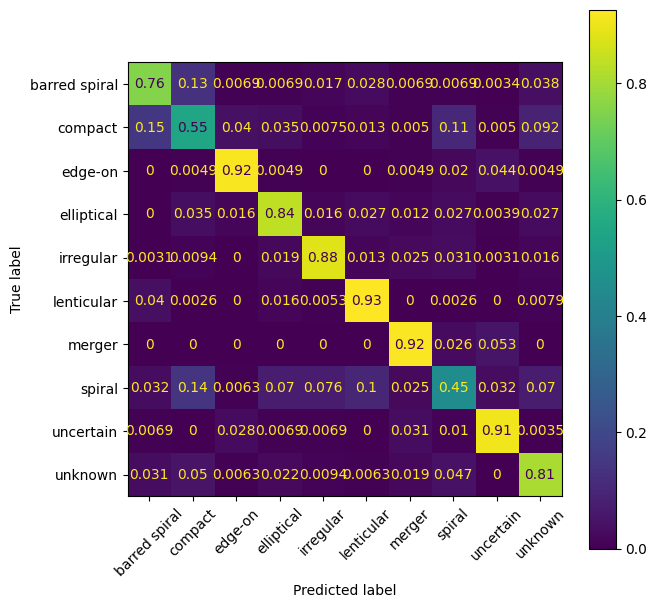

In [78]:
print(classification_report(y_true_labels, y_pred_labels))


fig, ax = plt.subplots(figsize=(7, 7))

# Mostrar la matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_true_labels,
    y_pred_labels,
    normalize="true",
    #cmap="Blues",
    ax=ax
)

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

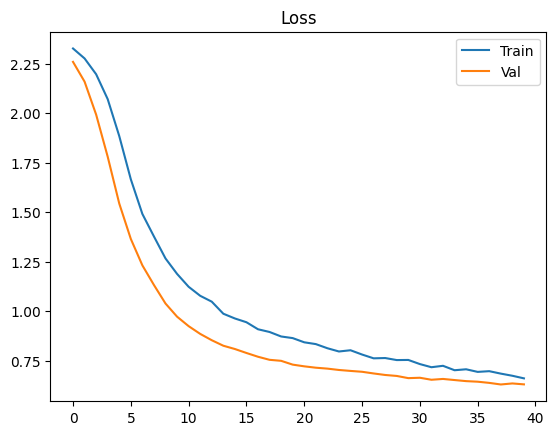

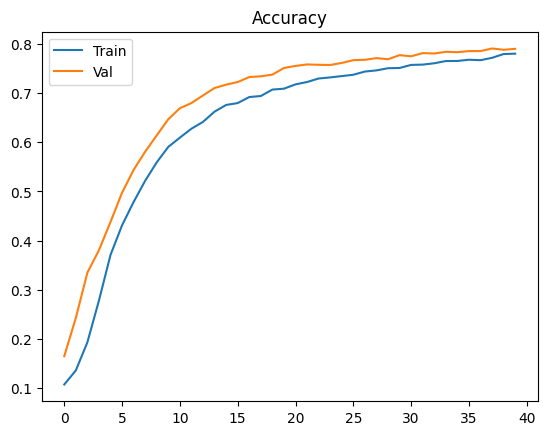

In [79]:
# CURVAS DE ENTRENAMIENTO
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend(); plt.title("Loss")
plt.show()

plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.legend(); plt.title("Accuracy")
plt.show()

In [48]:
#   GUARDAR MODELO
model.save("/content/modelo_galaxias.keras")